In [22]:
# pip instal _
#  pandas>=1.5.0
# mysql-connector-python>=8.0.0
# numpy>=1.21.0
# python-dotenv>=0.19.0 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "results/DPU+Explanations+-+Prolific+-+BetweenSubject+-+Pilot.csv"
qualtrics_results = pd.read_csv(csv_path)

# Parse StartDate and EndDate as datetime, coerce errors, and use dayfirst if your data is in that format
qualtrics_results['StartDate'] = pd.to_datetime(qualtrics_results['StartDate'], errors='coerce', dayfirst=True)
qualtrics_results['EndDate'] = pd.to_datetime(qualtrics_results['EndDate'], errors='coerce', dayfirst=True)

# Drop rows where parsing failed (NaT)
qualtrics_results = qualtrics_results.dropna(subset=['StartDate', 'EndDate'])
qualtrics_results.columns


C:\Users\matan\AppData\Local\Temp\ipykernel_31216\3647228946.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  qualtrics_results['StartDate'] = pd.to_datetime(qualtrics_results['StartDate'], errors='coerce', dayfirst=True)
C:\Users\matan\AppData\Local\Temp\ipykernel_31216\3647228946.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  qualtrics_results['EndDate'] = pd.to_datetime(qualtrics_results['EndDate'], errors='coerce', dayfirst=True)


Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q389_Browser', 'Q389_Version',
       'Q389_Operating System', 'Q389_Resolution',
       'Consent timing_First Click', 'Consent timing_Last Click',
       'Consent timing_Page Submit', 'Consent timing_Click Count', 'Consent',
       'prolific_id', 'Q1_First Click', 'Q1_Last Click', 'Q1_Page Submit',
       'Q1_Click Count', 'Q118_First Click', 'Q118_Last Click',
       'Q118_Page Submit', 'Q118_Click Count', 'Q110', 'Q160', 'Q163', 'Q165',
       'Q178', 'Q164', 'Q179', 'Q608_First Click', 'Q608_Last Click',
       'Q608_Page Submit', 'Q608_Click Count', 'Q609', 'Tutorial', 'Q613',
       'Q653_First Click', 'Q653_Last Click', 'Q653_Page Submit',
       'Q653_Click Co

In [24]:
import numpy as np
import pandas as pd
target_date = pd.to_datetime('2025-07-22')
next_day = target_date + pd.Timedelta(days=1)

# Ensure group is int
qualtrics_results['group'] = qualtrics_results['group'].astype(int)

# Get the correct start/end seconds for each row
start_seconds = qualtrics_results.apply(
    lambda row: row['Q193_First Click'] if row['group'] != 0 else row['Q192_First Click'], axis=1)
end_seconds = qualtrics_results.apply(
    lambda row: row['Q193_Page Submit'] if row['group'] != 0 else row['Q192_Page Submit'], axis=1)

# Convert to numeric (in case of string)
start_seconds = pd.to_numeric(start_seconds, errors='coerce').fillna(0)
end_seconds = pd.to_numeric(end_seconds, errors='coerce').fillna(0)

# Calculate new session start/end times
qualtrics_results['SessionStart'] = qualtrics_results['StartDate'] + pd.to_timedelta(start_seconds, unit='s')
qualtrics_results['SessionEnd'] = qualtrics_results['StartDate'] + pd.to_timedelta(end_seconds, unit='s')

# Use SessionStart and SessionEnd for session filtering
mask = (qualtrics_results['SessionStart'] < next_day) & (qualtrics_results['SessionEnd'] >= target_date)
sessions = qualtrics_results[mask].copy()

if not sessions.empty:
    first_minute = sessions['SessionStart'].min().replace(second=0, microsecond=0)
    last_minute = sessions['SessionEnd'].max().replace(second=0, microsecond=0)
    all_minutes = pd.date_range(first_minute, last_minute, freq='min')
    counts = []
    for minute in all_minutes:
        count = ((sessions['SessionStart'] <= minute) & (sessions['SessionEnd'] >= minute)).sum()
        counts.append(count)
    plt.figure(figsize=(16, 5))
    plt.bar(all_minutes, counts, width=0.02)
    plt.xlabel('Time (minute)')
    plt.ylabel('Number of users connected')
    plt.title('Number of users connected per minute on 2025-07-21 (custom session window)')
    plt.tight_layout()
    plt.show()
else:
    print("No sessions found for the specified date.")

C:\Users\matan\AppData\Local\Temp\ipykernel_31216\4049806730.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [25]:
# import sys
# import os
# sys.path.append(os.getcwd())
from mysql_data_explorer import get_all_tables_from_mysql, alter_database_tables
import pandas as pd

all_tabels = get_all_tables_from_mysql()
print(all_tabels.keys())

✅ Connected to Azure MySQL database: mysql_dpu
📊 Found 6 tables: ['actions', 'feedback_actions', 'player', 'tutorial_actions', 'user_choices', 'users']


c:\Users\matan\master_thesis\minigrid_custom\mysql_data_explorer.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection)
c:\Users\matan\master_thesis\minigrid_custom\mysql_data_explorer.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection)


   ✅ Loaded 'actions': 0 rows, 11 columns
   ✅ Loaded 'feedback_actions': 665 rows, 12 columns
   ✅ Loaded 'player': 1 rows, 2 columns
   ✅ Loaded 'tutorial_actions': 2995 rows, 8 columns
   ✅ Loaded 'user_choices': 219 rows, 13 columns
   ✅ Loaded 'users': 45 rows, 4 columns
🔌 Database connection closed
dict_keys(['actions', 'feedback_actions', 'player', 'tutorial_actions', 'user_choices', 'users'])


In [26]:
# alter_database_tables("ALTER TABLE feedback_actions ADD COLUMN feedback_unique_env INT;")

In [27]:
feedback_actions = all_tabels['feedback_actions']
feedback_actions['feedback_unique_env'] = feedback_actions['feedback_unique_env'].fillna(0).astype(int)

feedback_actions.columns

Index(['id', 'user_id', 'env_state', 'agent_action', 'feedback_action',
       'feedback_explanation', 'action_index', 'timestamp', 'episode_index',
       'agent_path', 'similarity_level', 'feedback_unique_env'],
      dtype='object')

In [38]:
import numpy as np

user_choices = all_tabels['user_choices']
# Fill 'unique_env' with random integers between 1 and 18 where it is None or NaN
user_choices['unique_env'] = user_choices['unique_env'].fillna(0).astype(int)
user_choices.tail(3)

,id,user_id,old_agent_path,new_agent_path,timestamp,demonstration_time,episode_index,choice_to_update,choice_explanation,simillarity_level,feedback_count,feedback_score,unique_env,choice_time,time_since_feedback
216,217,1015,"models/3,3,3,0.1,0.1Steps100Grid8_20250602/bes...","models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/be...",2025-07-27 21:02:35,2025-07-27 20:59:03,1,1,,4,2.0,2.0,2,2025-07-27 21:02:35,NaN
217,218,1015,"models/3,3,3,0.1,0.1Steps100Grid8_20250602/bes...","models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...",2025-07-27 21:14:13,2025-07-27 21:13:46,1,0,,4,2.0,2.0,2,2025-07-27 21:14:13,NaN
218,219,1015,"models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...","models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/be...",2025-07-27 21:14:55,2025-07-27 21:14:50,2,0,,4,4.0,4.0,12,2025-07-27 21:14:55,NaN


In [29]:
# Filter user_choises after 2025-07-15 (timestamp is str, format: 'YYYY-MM-DD HH:MM:SS')
user_choices['timestamp'] = pd.to_datetime(user_choices['timestamp'], format='%Y-%m-%d %H:%M:%S')
feedback_actions['timestamp'] = pd.to_datetime(feedback_actions['timestamp'], format='%Y-%m-%d %H:%M:%S')
filter_date = pd.to_datetime('2025-07-21')
user_choises_after_date = user_choices[user_choices['timestamp'] > filter_date]
feedback_actions_after_date = feedback_actions[feedback_actions['timestamp'] > filter_date]
print(user_choises_after_date['timestamp'].min(), user_choises_after_date['timestamp'].max())
print(feedback_actions_after_date['timestamp'].min(), feedback_actions_after_date['timestamp'].max())

2025-07-21 06:18:53 2025-07-27 21:14:55
2025-07-21 09:18:43 2025-07-28 00:14:48


In [30]:

prolific_id = "6818aa3b091f461c436e4f12"
specific_choises = user_choices[user_choices['user_id'] == prolific_id]
specific_feebacks = feedback_actions[feedback_actions['user_id'] == prolific_id]
print(specific_feebacks.shape)
print(specific_choises.shape)

(3, 12)
(1, 13)


In [31]:
# show the feedback board
from minigrid_custom_env import *
from minigrid_custom_train import *
from dpu_clf import *
from termcolor import colored
import ast

def print_state_grid(state):
    print("Grid View:")
    for i in range(7):
        row = ""
        for j in range(6,-1, -1):
            obj_idx, color_idx, _ = state[i][j]
            obj_name = IDX_TO_OBJECT.get(obj_idx, '???')
            color_name = IDX_TO_COLOR.get(color_idx, 'white')
            # cell_str = colored(f"{obj_name[:3]}", color='1')
            if obj_name == 'empty':
                row += "[ ] "
            elif obj_name == 'wall':
                row += "[#] "
            elif obj_name == 'ball':
                # Use the first letter of the object and color for compactness
                row += f"[{color_name[0].upper()}] "
            else:
                row += f"[{obj_name[0].upper()}] "
        print(row)

feedbacks = feedback_actions[feedback_actions['user_id'] == prolific_id]
index = 0
for i in range(len(feedbacks)):
    print(f"index: {i}, agent_action: {list(feedbacks['agent_action'])[i]}, feedback_action: {list(feedbacks['feedback_action'])[i]}")
    state = ast.literal_eval(list(feedbacks['env_state'])[i])
    print_state_grid(state)

index: 0, agent_action: 2, feedback_action: 1
Grid View:
[#] [#] [#] [#] [#] [#] [#] 
[#] [#] [#] [#] [#] [#] [#] 
[#] [#] [#] [#] [#] [#] [#] 
[ ] [L] [G] [#] [#] [#] [#] 
[ ] [ ] [R] [#] [#] [#] [#] 
[B] [ ] [ ] [#] [#] [#] [#] 
[ ] [ ] [ ] [#] [#] [#] [#] 
index: 1, agent_action: 2, feedback_action: 0
Grid View:
[#] [#] [#] [#] [#] [#] [#] 
[#] [#] [#] [#] [#] [#] [#] 
[ ] [ ] [B] [ ] [G] [#] [#] 
[ ] [L] [ ] [ ] [ ] [#] [#] 
[ ] [L] [ ] [ ] [R] [#] [#] 
[ ] [L] [ ] [G] [ ] [#] [#] 
[ ] [ ] [ ] [ ] [G] [#] [#] 
index: 2, agent_action: 1, feedback_action: 0
Grid View:
[#] [#] [#] [#] [#] [#] [#] 
[#] [#] [#] [#] [#] [#] [#] 
[ ] [ ] [ ] [ ] [G] [#] [#] 
[ ] [L] [ ] [ ] [ ] [#] [#] 
[ ] [L] [ ] [ ] [ ] [#] [#] 
[L] [ ] [ ] [ ] [ ] [#] [#] 
[ ] [ ] [ ] [ ] [ ] [#] [#] 


In [32]:
user_choise = user_choices[user_choices['user_id'] == prolific_id].iloc[0]
old = user_choise['old_agent_path']
new = user_choise['new_agent_path']
print(old)
print(new)

models/3,3,3,0.1,0.1Steps100Grid8_20250602/best_model.zip
models/2,2,4,-4,0.1Steps50Grid8_20250617/best_model.zip


In [33]:
print(user_choises_after_date[['user_id', 'feedback_count', 'feedback_score', 'choice_to_update', 'episode_index']])

                        user_id  feedback_count  feedback_score  \
94                           87             4.0             4.0   
95                           87             7.0             6.0   
96                           87            12.0            11.0   
97                           87            16.0            13.0   
98                           87            18.0            15.0   
..                          ...             ...             ...   
214  Y6757575757575757575757575             8.0             6.0   
215  Y6757575757575757575757575             9.0             7.0   
216                        1015             2.0             2.0   
217                        1015             2.0             2.0   
218                        1015             4.0             4.0   

     choice_to_update  episode_index  
94                  1              1  
95                  0              2  
96                  0              3  
97                  1              4  


In [34]:
import pandas as pd
def calculate_choice_times(user_choices_df, feedback_actions_df):
    """
    Calculate time difference between feedback and choices
    """
    print("⏱️ Calculating choice times...")
    
    # Convert timestamps to datetime
    user_choices_df['choice_time'] = pd.to_datetime(user_choices_df['timestamp'])
    feedback_actions_df['feedback_time'] = pd.to_datetime(feedback_actions_df['timestamp'])
    
    # Initialize time differences list
    time_diffs = []
    
    for idx, choice in user_choices_df.iterrows():
        user_id = choice['user_id']
        choice_time = choice['choice_time']
        old_agent_path = choice['old_agent_path']
        
        # Find relevant feedback actions
        relevant_feedback = feedback_actions_df[
            (feedback_actions_df['user_id'] == user_id) &
            (feedback_actions_df['agent_path'] == old_agent_path) &
            (feedback_actions_df['feedback_time'] < choice_time) &
            (feedback_actions_df['feedback_time'] > (choice_time - pd.Timedelta(minutes=5)))
        ]
        
        if len(relevant_feedback) > 0:
            # Get the latest feedback before the choice
            latest_feedback = relevant_feedback.loc[relevant_feedback['feedback_time'].idxmax()]
            feedback_time = latest_feedback['feedback_time']
            
            # Calculate time difference in seconds
            time_diff = (choice_time - feedback_time).total_seconds()
            time_diffs.append(time_diff)
            
            print(f"User {user_id}: {time_diff:.1f}s between feedback and choice")
        else:
            time_diffs.append(None)
            print(f"User {user_id}: No relevant feedback found")
    
    # Add time differences to the dataframe
    user_choices_df['time_since_feedback'] = time_diffs
    
    return user_choices_df

# Run the analysis
user_choices_with_times = calculate_choice_times(user_choices, feedback_actions)

# Show results
print(f"\n📊 Time analysis results:")
print(user_choices_with_times[['user_id', 'choice_to_update', 'simillarity_level', 'time_since_feedback']].head(10))

# Summary by similarity level
print(f"\n⏱️ Average time by similarity level:")
for level in range(5):
    level_data = user_choices_with_times[user_choices_with_times['simillarity_level'] == level]
    if len(level_data) > 0:
        avg_time = level_data['time_since_feedback'].mean()
        print(f"Level {level}: {avg_time:.1f}s average")

⏱️ Calculating choice times...
User 70: 8.0s between feedback and choice
User 70: 9.0s between feedback and choice
User 70: 9.0s between feedback and choice
User 67: 20.0s between feedback and choice
User 67: 14.0s between feedback and choice
User 67: 10.0s between feedback and choice
User 67: 37.0s between feedback and choice
User 96: 7.0s between feedback and choice
User 96: 25.0s between feedback and choice
User 96: 9.0s between feedback and choice
User 96: 7.0s between feedback and choice
User 7: 7.0s between feedback and choice
User 7: 47.0s between feedback and choice
User 7: 11.0s between feedback and choice
User 7: 10.0s between feedback and choice
User 100: 13.0s between feedback and choice
User 100: 8.0s between feedback and choice
User 100: 16.0s between feedback and choice
User 100: 8.0s between feedback and choice
User 100: 15.0s between feedback and choice
User 101: 26.0s between feedback and choice
User 101: 14.0s between feedback and choice
User 101: 10.0s between feedb

In [35]:
models_eval = {'3,3,3,0.1,0.1Steps100Grid8_20250602': -3.584860000000017, 
 '3,3,4,0.2,0.05Steps50Grid8_20250604': -16.003919999999667, 
 '2,2,4,-4,0.1Steps50Grid8_20250617': 3.3411399999999576, 
 '-1,-1,4,0.2,0.1Steps70Grid8_20250625': -3.6720200000000305, 
 '-0.5,2,4,-3,0.1Steps50Grid8_20250612_good': 4.5956399999999, 
 '-0.5,3,4,0.2,0.1Steps50Grid8_20250616': 0.7418600000000011, 
 '-1,4,-1,0.2,0.1Steps60Grid8_20250618': -3.6132600000000124, 
 '-1,3,4,-3,0.1Steps60Grid8_20250618': 2.717980000000023, 
 '-0.5,3,4,-3,0.1Steps50Grid8_20250616': 4.7921799999998855,
  '-1,3,4,0.2,0.2Steps50Grid8_20250617': 0.7431600000000003}


def calculate_correct_answers_by_similarity_level(user_choices_df, models_eval_dict):
    """
    Calculate correct answers for each similarity level (0-4)
    """
    print("🔍 Analyzing user choices...")
    
    # Extract model names from agent paths
    def extract_model_name(path):
        if pd.isna(path):
            return None
        if 'models/' in str(path):
            parts = str(path).split('/')
            if len(parts) >= 2:
                return parts[1]  # Get model folder name
        return str(path)
    
    # Create new columns with extracted model names
    user_choices_df = user_choices_df.copy()
    user_choices_df['old_model_name'] = user_choices_df['old_agent_path'].apply(extract_model_name)
    user_choices_df['new_model_name'] = user_choices_df['new_agent_path'].apply(extract_model_name)
    
    # Get values for old and new models
    user_choices_df['old_value'] = user_choices_df['old_model_name'].map(models_eval_dict)
    user_choices_df['new_value'] = user_choices_df['new_model_name'].map(models_eval_dict)
    
    # Remove rows with missing values
    final_df = user_choices_df.dropna(subset=['old_value', 'new_value'])
    print(f"📊 Clean data shape: {final_df.shape}")
    
    # Calculate correct decisions
    final_df['correct_decision'] = (
        ((final_df['choice_to_update'] == 1) & (final_df['new_value'] >= final_df['old_value'])) |
        ((final_df['choice_to_update'] == 0) & (final_df['new_value'] <= final_df['old_value']))
    )
    
    # Calculate correct answers for each similarity level
    correct_answers_by_level = []
    
    print("\n📈 Results by similarity level:")
    for level in range(5):
        level_data = final_df[final_df['simillarity_level'] == level]
        
        if len(level_data) > 0:
            correct_decisions = level_data['correct_decision'].sum()
            total_decisions = len(level_data)
            accuracy = correct_decisions / total_decisions
            accuracy = round(accuracy, 2)
            
            print(f"🎚️ Level {level}: {correct_decisions}/{total_decisions} correct ({accuracy*100:.1f}%)")
            correct_answers_by_level.append(accuracy)
        else:
            print(f"��️ Level {level}: No data")
            correct_answers_by_level.append(0)
    
    return correct_answers_by_level

# Run the analysis
correct_answers = calculate_correct_answers_by_similarity_level(user_choices, models_eval)
print(f"\n🎯 Final Result: {correct_answers}")


import matplotlib.pyplot as plt

groups = ['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']

plt.figure(figsize=(8, 5))
bars = plt.bar(groups, [c * 100 for c in correct_answers], color=colors)

plt.ylabel('Correctness (%)')
plt.title('Correctness by Similarity Level')
plt.ylim(0, 100)
plt.legend(bars, groups, title="Similarity Level")
plt.show()

🔍 Analyzing user choices...
📊 Clean data shape: (209, 19)

📈 Results by similarity level:
🎚️ Level 0: 2/5 correct (40.0%)
🎚️ Level 1: 5/25 correct (20.0%)
🎚️ Level 2: 23/59 correct (39.0%)
🎚️ Level 3: 13/49 correct (27.0%)
🎚️ Level 4: 26/71 correct (37.0%)

🎯 Final Result: [0.4, 0.2, 0.39, 0.27, 0.37]


C:\Users\matan\AppData\Local\Temp\ipykernel_31216\772400087.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['correct_decision'] = (
C:\Users\matan\AppData\Local\Temp\ipykernel_31216\772400087.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Real stuff

In [36]:
unique_envs_scores = {'AllColorsLL1_0526': [0, 0.6, 5.8, 8.0, 3.0, 7.5, -3.4, -1.5, 6.0, 1.5, 1.0, 0.6, 4.1, 4.1, -10.4, -0.2, 2.1, 4.3, 4.6],
                    'AllColorsLL2_0604': [0, -1.0, 5.5, 3.2, 3.0, 7.8, -3.4, 1.9, 7.5, 1.2, -8.0, 0.6, 4.1, 9.3, -6.0, -0.2, -7.0, 4.8, 0.9],
                    'AllColorsLH_0617': [0, 4.5, 6.2, 8.7, 4.8, 8.5, -7.0, 2.1, 7.5, 6.4, 0.8, 4.2, 5.1, -47.0, 0.3, 2.1, 6.9, 4.1, -0.0],
                    'OnlyBlueLL_0625': [0, -2.5, 3.3, -3.1, 3.5, 6.1, 2.5, 0.5, 7.3, 1.1, 2.8, 3.6, -0.8, 5.8, -3.8, -1.9, 2.5, -53.0, 3.0],
                    'NoRedLH1_0612': [0, 4.8, 6.5, 10.3, 5.2, 4.8, 3.2, 5.0, 7.1, 9.5, -1.0, 6.9, 5.2, -27.0, 0.3, -53.0, 5.0, 5.2, 5.1],
                    'NoRedLL_0616': [0, 1.4, 5.8, 6.3, 3.0, 5.5, 1.2, 2.1, 7.3, 3.4, 2.3, 6.6, 4.1, 6.1, 0.3, 0.9, 4.2, 5.2, 4.3],
                    'OnlyGreenLL_0429': [0, 1.2, 4.1, 3.9, 3.0, 0.2, -4.9, -4.5, 1.3, 3.2, -12.5, -6.9, 0.1, -4.7, -12.5, -1.8, -8.7, 1.5, -0.7],
                    'NoRedLH2_0618': [0, 4.8, 6.5, 10.3, 5.1, 9.6, 4.8, 1.0, 8.4, 6.5, -5.0, 5.5, 6.5, -47.0, -4.0, -5.0, -46.0, 5.1, 5.0],
                    'NoRedLH3_0612': [0, 1.5, 7.1, 10.3, 5.1, 9.0, 4.8, -38.0, 8.4, 6.4, 3.3, 5.0, 6.4, -48.0, -4.0, -53.0, 3.1, 5.2, 5.1],
                    'NoRedLL_G_0617': [0, 1.9, 6.5, 8.0, 5.2, 7.5, 2.0, 2.1, 7.3, 4.2, 2.8, 6.9, 4.1, 5.8, -49.0, -3.0, 4.1, 5.0, 3.0],
                    'OnlyBlueLH_0706': [0, -0.4, 3.3, 8.6, 3.5, 3.2, 2.4, 2.3, 7.3, 6.8, 6.3, 3.6, 2.2, 3.0, -5.0, 1.6, 0.2, 5.6, 2.8],}

new_models_dict = {
    1: {'path': 'models/3,3,3,0.1,0.1Steps100Grid8_20250602/best_model.zip', 'name': 'AllColorsLL1_0526', 'vector': (3, 3, 3, 0.1, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]},
    2: {'path': 'models/3,3,4,0.2,0.05Steps50Grid8_20250604/best_model.zip', 'name': 'AllColorsLL2_0604', 'vector': (3, 3, 4, 0.2, 0.05), 'optional_unique_env':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18]},
    3: {'path': 'models/2,2,4,-4,0.1Steps50Grid8_20250617/best_model.zip', 'name': 'AllColorsLH_0617', 'vector': (2, 2, 4, -3, 0.1), 'optional_unique_env':  [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]},
    4: {'path': 'models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/best_model.zip', 'name': 'OnlyBlueLL_0625', 'vector': (-1, -1, 4, 0.2, 0.1), 'optional_unique_env':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]},
    5: {'path': 'models/-0.5,2,4,-3,0.1Steps50Grid8_20250612_good/best_model.zip', 'name': 'NoRedLH1_0612', 'vector': (-0.5, 2, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 17, 18]},
    6: {'path': 'models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/best_model.zip', 'name': 'NoRedLL_0616', 'vector': (-0.5, 3, 4, 0.2, 0.1), 'optional_unique_env':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]},
    7: {'path': 'models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/best_model', 'name': 'OnlyGreenLL_0429', 'vector': (-0.1, 3, -0.1, 0, 0.01), 'optional_unique_env':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]},
    8: {'path': 'models/-1,3,4,-3,0.1Steps60Grid8_20250618/best_model.zip', 'name': 'NoRedLH2_0618', 'vector': (-1, 3, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 17, 18]},
    9: {'path': 'models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/best_model.zip', 'name': 'NoRedLH3_0612', 'vector': (-0.5, 3, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 16, 17, 18]},
    10: {'path': 'models/-1,3,4,0.2,0.2Steps50Grid8_20250617/best_model.zip', 'name': 'NoRedLL_G_0617', 'vector': (-1, 3, 4, 0.2, 0.2), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18]},
    11: {'path': 'models/-1,-1,4,-3,0.1Steps100Grid8_20250706/best_model.zip', 'name': 'OnlyBlueLH_0706', 'vector': (-1, -1, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18]}
}

path_to_name = {v['path']: v['name'] for v in new_models_dict.values()}



In [37]:
def create_user_results_df(user_choices_df, feedback_actions_df, unique_envs_scores, path_to_name, qualtrics_df=None):
    """
    Create user_results DataFrame with columns for each episode (1-5):
    user_id, similarity_level, feedback_score1-5, choice1-5, good_choice1-5, choice_time1-5, update_agent1-5, Trust_the_agent
    
    Parameters:
    trust_mapping: dict - Manual mapping of user_id to Trust_the_agent values (Q594)
    """
    print("🔄 Creating user_results DataFrame...")
    
    # Get unique users
    unique_users = user_choices_df['user_id'].unique()
    
    # Initialize results list
    results = []
    
    for user_id in unique_users:
        # print(f"📊 Processing user: {user_id}")
        
        # Get user's choices and feedback
        user_choices = user_choices_df[user_choices_df['user_id'] == user_id].copy()
        user_feedback = feedback_actions_df[feedback_actions_df['user_id'] == user_id].copy()
        
        if len(user_choices) == 0:
            continue
            
        # Get similarity level (should be same for all choices of a user)
        similarity_level = user_choices['simillarity_level'].iloc[0] if 'simillarity_level' in user_choices.columns else None
        
        # Get Trust_the_agent from qualtrics Q594 if available
        trust_the_agent = None
        trust_question_number = 'Q594'  # Default question number for Trust_the_agent
        if qualtrics_df is not None and trust_question_number in qualtrics_df.columns:
            # Try to find matching user in qualtrics data
            # Direct prolificID match (if available)
            if 'ProlificID' in qualtrics_df.columns:
                qualtrics_match = qualtrics_df[qualtrics_df['ProlificID'] == user_id]
                if len(qualtrics_match) > 0:
                    trust_the_agent = qualtrics_match[trust_question_number].iloc[0]
            
                # # If no direct match, try numeric matching
                # if trust_the_agent is None and str(user_id).isdigit():
                #     user_id_numeric = int(user_id)
                #     # Check if there's a numeric column that might match
                #     for col in ['participant_id', 'user_number', 'id']:
                #         if col in qualtrics_df.columns:
                #             numeric_matches = pd.to_numeric(qualtrics_df[col], errors='coerce')
                #             match_idx = numeric_matches == user_id_numeric
                #             if match_idx.any():
                #                 trust_the_agent = qualtrics_df.loc[match_idx, 'Q594'].iloc[0]
                #                 break
        
        # Initialize user result
        user_result = {
            'user_id': user_id,
            'similarity_level': similarity_level,
            'Trust_the_agent': int(trust_the_agent) if trust_the_agent is not None else None,  # -1 if not available
        }
        
        # Sort choices and feedback by episode index
        user_choices = user_choices.sort_values('episode_index')
        user_feedback = user_feedback.sort_values('timestamp')
        
        # Process each episode (1-5)
        for episode in range(1, 6):
            episode_choices = user_choices[user_choices['episode_index'] == episode]
            
            if len(episode_choices) > 0:
                choice_data = episode_choices.iloc[0]  # Take first choice for this episode
                unique_env = int(choice_data.get('unique_env', 0))
                
                # Get choice information
                choice = choice_data['choice_to_update']
                old_path = choice_data['old_agent_path']
                new_path = choice_data['new_agent_path']
                
                # Get model names from paths
                old_model_name = path_to_name.get(old_path, None)
                new_model_name = path_to_name.get(new_path, None)
                
                # Calculate good_choice
                good_choice = None
                if old_model_name and new_model_name and old_model_name in unique_envs_scores and new_model_name in unique_envs_scores:
                    # Get scores for the specific episode (episode index corresponds to position in scores list)
                    if unique_env <= len(unique_envs_scores[old_model_name]) and unique_env <= len(unique_envs_scores[new_model_name]):
                        old_score = unique_envs_scores[old_model_name][unique_env]
                        new_score = unique_envs_scores[new_model_name][unique_env]
                        
                        # Good choice = 1 if user chose to update and new is better, or chose not to update and old is better
                        if choice == 1:  # User chose to update
                            good_choice = 1 if new_score >= old_score else 0
                        else:  # User chose not to update
                            good_choice = 1 if old_score >= new_score else 0
                
                # Get feedback score for this episode
                feedback_score = choice_data.get('feedback_score', None)
                
                # Get choice time (time_since_feedback)
                choice_time = choice_data.get('time_since_feedback', None)
                
                # Add to user result
                user_result[f'feedback_score{episode}'] = feedback_score
                user_result[f'choice{episode}'] = choice
                user_result[f'good_choice{episode}'] = good_choice
                user_result[f'choice_time{episode}'] = choice_time
                
                # Add update_agent column (1 if feedback_score exists, 0 if NaN)
                user_result[f'update_agent{episode}'] = 1 if pd.notna(feedback_score) else 0
                
            else:
                # No data for this episode
                user_result[f'feedback_score{episode}'] = None
                user_result[f'choice{episode}'] = None
                user_result[f'good_choice{episode}'] = None
                user_result[f'choice_time{episode}'] = None
                user_result[f'update_agent{episode}'] = 0
        
        results.append(user_result)
    
    # Create DataFrame
    user_results = pd.DataFrame(results)
    
    print(f"✅ Created user_results DataFrame with {len(user_results)} users")
    print(f"📊 Columns: {list(user_results.columns)}")
    
    return user_results

# Create the user_results DataFrame
user_results = create_user_results_df(
    user_choices_with_times, 
    feedback_actions, 
    unique_envs_scores, 
    path_to_name,
    qualtrics_results,  # Pass qualtrics data
)

# Display basic information
print(f"\n📈 User Results Summary:")
print(f"Shape: {user_results.shape}")
print(f"Users: {len(user_results)}")
print(f"Similarity levels: {sorted(user_results['similarity_level'].unique())}")

# Show first few rows
print(f"\n🔍 First 3 users:")
print(user_results.head(3))

🔄 Creating user_results DataFrame...


ValueError: cannot convert float NaN to integer

In [ ]:
users_ids = ['Matan12222222222222222222222222222', 'Nir12345122141235132512561', 'ivri123456789101112131415', '20000000000000000000000000000000000000', '100000000000000000000000000']
filtered_user_results = user_results[user_results['user_id'].isin(users_ids)]
print(filtered_user_results)

                                   user_id  similarity_level Trust_the_agent  \
38               ivri123456789101112131415                 2               1   
39      Matan12222222222222222222222222222                 3             NaN   
42              Nir12345122141235132512561                 0               1   
46             100000000000000000000000000                 3               2   
47  20000000000000000000000000000000000000                 2               1   

    feedback_score1  choice1  good_choice1  choice_time1  update_agent1  \
38              3.0      1.0           1.0          21.0              1   
39              1.0      0.0           0.0          58.0              1   
42              NaN      NaN           NaN           NaN              0   
46              1.0      0.0           1.0           8.0              1   
47              2.0      0.0           0.0         215.0              1   

    feedback_score2  choice2  ...  feedback_score4  choice4  good_ch

📊 Creating visualizations based on user_results...

1️⃣ Calculating average good_choice percentage by group...
Level 1: 41.2% (17 total choices)
Level 2: 66.0% (53 total choices)
Level 3: 35.0% (40 total choices)
Level 4: 52.8% (53 total choices)


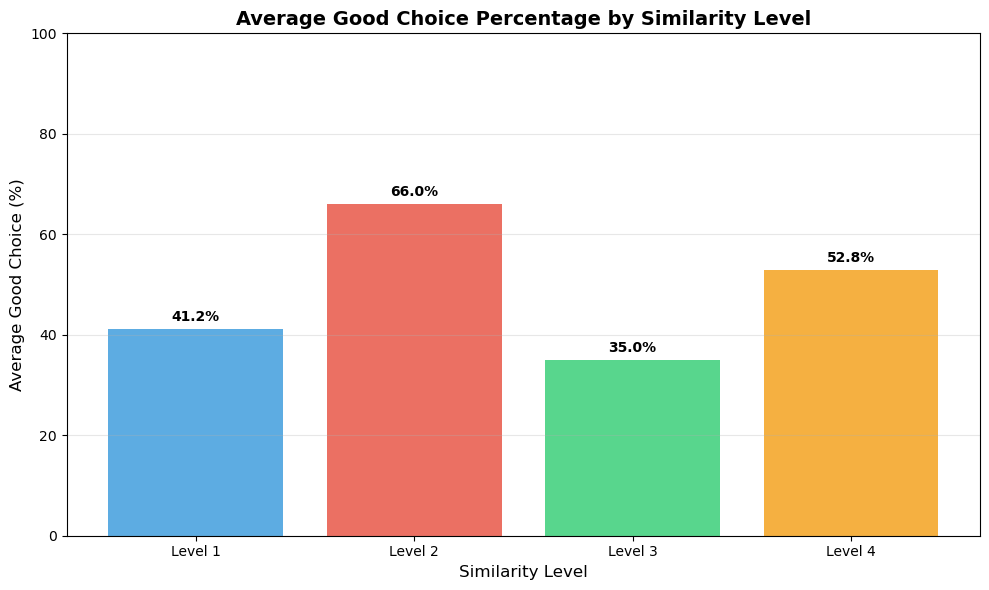

✅ Plot 1 completed: Average good choice percentages: ['41.2%', '66.0%', '35.0%', '52.8%']


In [ ]:
# Create visualizations based on user_results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for Jupyter notebook - use inline backend
%matplotlib inline

# Set up nice color palettes
plt.style.use('default')
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']  # Nice blues, reds, greens, oranges, purples
sns.set_palette("husl")

print("📊 Creating visualizations based on user_results...")

# 1. Average good_choice percentage by similarity level
print("\n1️⃣ Calculating average good_choice percentage by group...")

# Collect all good_choice columns
good_choice_cols = [col for col in user_results.columns if col.startswith('good_choice')]

# Calculate average good_choice for each similarity level
similarity_levels = sorted(user_results['similarity_level'].unique())[1:]
good_choice_averages = []

for level in similarity_levels:
    level_data = user_results[user_results['similarity_level'] == level]
    
    # Get all good_choice values for this level (excluding NaN)
    all_good_choices = []
    for col in good_choice_cols:
        valid_choices = level_data[col].dropna()
        all_good_choices.extend(valid_choices.tolist())
    
    if all_good_choices:
        avg_percentage = np.mean(all_good_choices) * 100
        good_choice_averages.append(avg_percentage)
        print(f"Level {level}: {avg_percentage:.1f}% ({len(all_good_choices)} total choices)")
    else:
        good_choice_averages.append(0)
        print(f"Level {level}: No valid choices")

# Plot 1: Average good_choice percentage by group
plt.figure(figsize=(10, 6))
bars1 = plt.bar(range(len(similarity_levels)), good_choice_averages, 
               color=colors_palette[:len(similarity_levels)], alpha=0.8)
plt.xlabel('Similarity Level', fontsize=12)
plt.ylabel('Average Good Choice (%)', fontsize=12)
plt.title('Average Good Choice Percentage by Similarity Level', fontsize=14, fontweight='bold')
plt.xticks(range(len(similarity_levels)), [f'Level {level}' for level in similarity_levels])
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(good_choice_averages):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Plot 1 completed: Average good choice percentages: {[f'{x:.1f}%' for x in good_choice_averages]}")


2️⃣ Calculating average choice time by group...
Level 1: 10.9s (17 total choices)
Level 2: 29.7s (26 total choices)
Level 3: 16.8s (28 total choices)
Level 4: 17.9s (30 total choices)


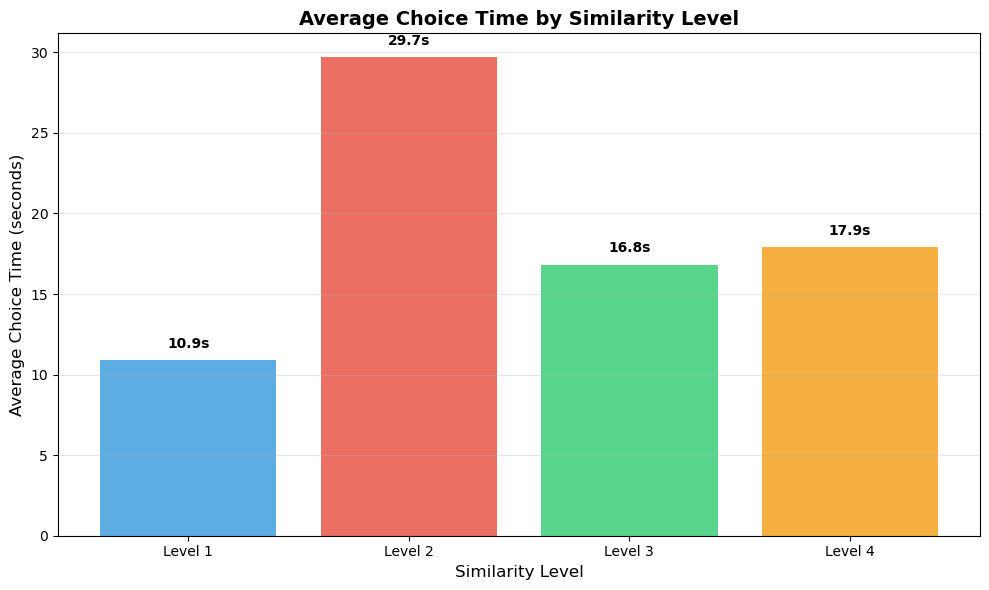

✅ Plot 2 completed: Average choice times: ['10.9s', '29.7s', '16.8s', '17.9s']


In [ ]:
# 2. Average choice time by similarity level
print("\n2️⃣ Calculating average choice time by group...")

# Collect all choice_time columns
choice_time_cols = [col for col in user_results.columns if col.startswith('choice_time')]

# Calculate average choice time for each similarity level
choice_time_averages = []

for level in similarity_levels:
    level_data = user_results[user_results['similarity_level'] == level]
    
    # Get all choice_time values for this level (excluding NaN)
    all_choice_times = []
    for col in choice_time_cols:
        valid_times = level_data[col].dropna()
        all_choice_times.extend(valid_times.tolist())
    
    if all_choice_times:
        avg_time = np.mean(all_choice_times)
        choice_time_averages.append(avg_time)
        print(f"Level {level}: {avg_time:.1f}s ({len(all_choice_times)} total choices)")
    else:
        choice_time_averages.append(0)
        print(f"Level {level}: No valid choice times")

# Plot 2: Average choice time by group
plt.figure(figsize=(10, 6))
bars2 = plt.bar(range(len(similarity_levels)), choice_time_averages, 
               color=colors_palette[:len(similarity_levels)], alpha=0.8)
plt.xlabel('Similarity Level', fontsize=12)
plt.ylabel('Average Choice Time (seconds)', fontsize=12)
plt.title('Average Choice Time by Similarity Level', fontsize=14, fontweight='bold')
plt.xticks(range(len(similarity_levels)), [f'Level {level}' for level in similarity_levels])

# Add value labels on bars
for i, v in enumerate(choice_time_averages):
    if v > 0:  # Only add label if there's data
        plt.text(i, v + max(choice_time_averages) * 0.02, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Plot 2 completed: Average choice times: {[f'{x:.1f}s' for x in choice_time_averages]}")


3️⃣ Calculating average choice time by episode and group...

Episode 1:
  Level 1: 12.0s (6 users)
  Level 2: 44.9s (8 users)
  Level 3: 14.5s (10 users)
  Level 4: 22.7s (7 users)

Episode 2:
  Level 1: 13.8s (4 users)
  Level 2: 26.8s (5 users)
  Level 3: 28.6s (5 users)
  Level 4: 17.8s (5 users)

Episode 3:
  Level 1: 9.8s (4 users)
  Level 2: 22.8s (6 users)
  Level 3: 15.3s (7 users)
  Level 4: 19.7s (6 users)

Episode 4:
  Level 1: 6.0s (2 users)
  Level 2: 22.0s (4 users)
  Level 3: 16.0s (2 users)
  Level 4: 11.7s (6 users)

Episode 5:
  Level 1: 7.0s (1 users)
  Level 2: 18.0s (3 users)
  Level 3: 11.0s (4 users)
  Level 4: 16.8s (6 users)


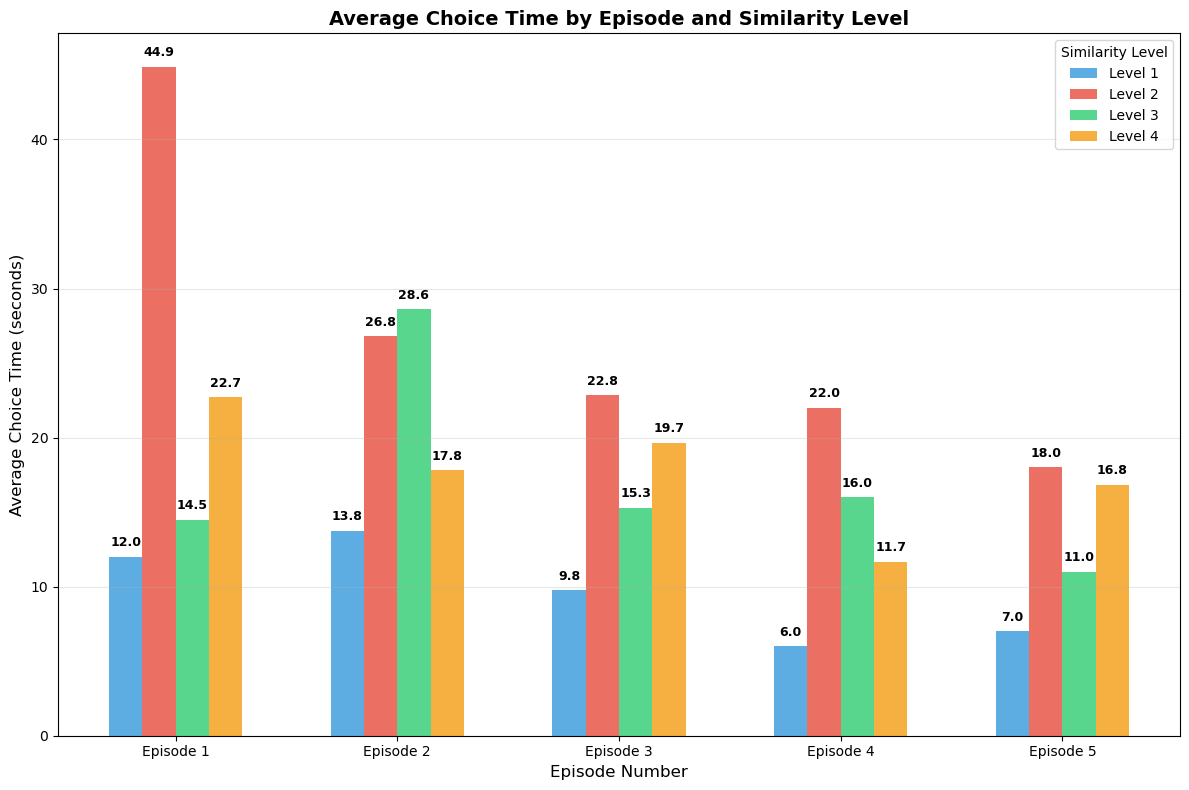

✅ Plot 3 completed: Choice time by episode and similarity level


In [ ]:
# 3. Average choice time for each episode and similarity level
print("\n3️⃣ Calculating average choice time by episode and group...")

# Create data for heatmap/grouped bar plot
episode_choice_times = {level: [] for level in similarity_levels}

for episode in range(1, 6):
    col_name = f'choice_time{episode}'
    print(f"\nEpisode {episode}:")
    
    for level in similarity_levels:
        level_data = user_results[user_results['similarity_level'] == level]
        valid_times = level_data[col_name].dropna()
        
        if len(valid_times) > 0:
            avg_time = valid_times.mean()
            episode_choice_times[level].append(avg_time)
            print(f"  Level {level}: {avg_time:.1f}s ({len(valid_times)} users)")
        else:
            episode_choice_times[level].append(0)
            print(f"  Level {level}: No valid times")

# Plot 3: Choice time by episode and group
plt.figure(figsize=(12, 8))

# Create grouped bar plot
episodes = list(range(1, 6))
x = np.arange(len(episodes))
width = 0.15

for i, level in enumerate(similarity_levels):
    offset = (i - len(similarity_levels)/2 + 0.5) * width
    bars = plt.bar(x + offset, episode_choice_times[level], width, 
                 label=f'Level {level}', color=colors_palette[i], alpha=0.8)
    
    # Add value labels on bars
    for j, v in enumerate(episode_choice_times[level]):
        if v > 0:  # Only show label if there's data
            plt.text(x[j] + offset, v + 0.5, f'{v:.1f}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')

plt.xlabel('Episode Number', fontsize=12)
plt.ylabel('Average Choice Time (seconds)', fontsize=12)
plt.title('Average Choice Time by Episode and Similarity Level', fontsize=14, fontweight='bold')
plt.xticks(x, [f'Episode {i}' for i in episodes])
plt.legend(title='Similarity Level', loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Plot 3 completed: Choice time by episode and similarity level")


4️⃣ Analyzing trust the agent by group...
Trust values: 1 = Do not trust, 2 = Trust, None = No answer

Level 1:
  Total users who answered: 2
  Users who trust (2): 1 (50.0%)
  Users who don't trust (1): 1 (50.0%)

Level 2:
  Total users who answered: 2
  Users who trust (2): 0 (0.0%)
  Users who don't trust (1): 2 (100.0%)

Level 3:
  Total users who answered: 2
  Users who trust (2): 2 (100.0%)
  Users who don't trust (1): 0 (0.0%)

Level 4:
  Total users who answered: 1
  Users who trust (2): 0 (0.0%)
  Users who don't trust (1): 1 (100.0%)


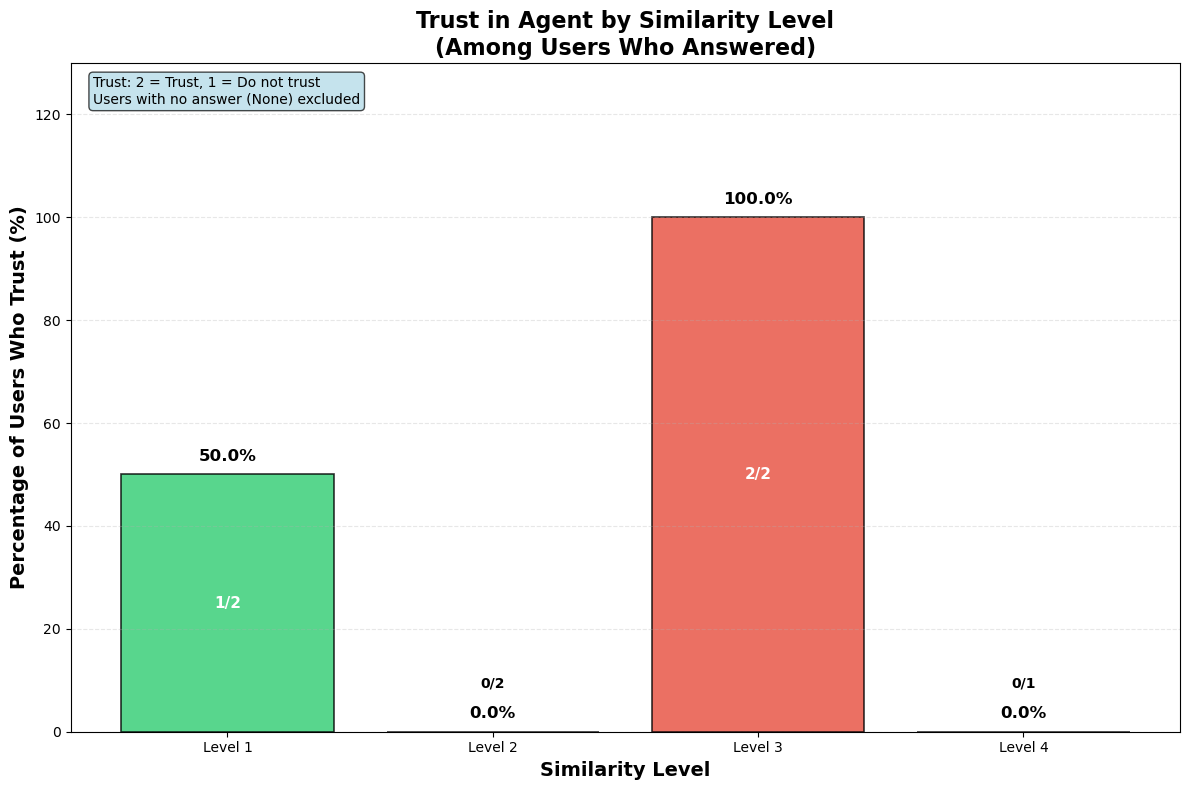


✅ Trust analysis completed!
📊 Summary:
Level 1: 1/2 trust (50.0%)
Level 2: 0/2 trust (0.0%)
Level 3: 2/2 trust (100.0%)
Level 4: 0/1 trust (0.0%)

🎉 All visualizations completed successfully!


In [ ]:
# 4. Trust the agent analysis by similarity level (Trust vs No Trust)
print("\n4️⃣ Analyzing trust the agent by group...")
print("Trust values: 1 = Do not trust, 2 = Trust, None = No answer")

# Calculate trust statistics for each similarity level (excluding None values)
trust_analysis = {}

for level in similarity_levels:
    level_data = user_results[user_results['similarity_level'] == level]
    
    # Remove None values (users who didn't answer)
    answered_data = level_data['Trust_the_agent'].dropna()
    
    total_answered = len(answered_data)
    trust_count = (answered_data == 2).sum()  # Count users who trust (value 2)
    no_trust_count = (answered_data == 1).sum()  # Count users who don't trust (value 1)
    
    if total_answered > 0:
        trust_percentage = (trust_count / total_answered) * 100
    else:
        trust_percentage = 0
    
    trust_analysis[level] = {
        'total_answered': total_answered,
        'trust_count': trust_count,
        'no_trust_count': no_trust_count,
        'trust_percentage': trust_percentage
    }
    
    print(f"\nLevel {level}:")
    print(f"  Total users who answered: {total_answered}")
    print(f"  Users who trust (2): {trust_count} ({trust_percentage:.1f}%)")
    print(f"  Users who don't trust (1): {no_trust_count} ({100-trust_percentage:.1f}%)")

# Prepare data for plotting
trust_percentages = [trust_analysis[level]['trust_percentage'] for level in similarity_levels]
trust_counts = [trust_analysis[level]['trust_count'] for level in similarity_levels]
total_answered = [trust_analysis[level]['total_answered'] for level in similarity_levels]

# Plot: Trust percentage among respondents
plt.figure(figsize=(12, 8))

# Create bar plot
x = np.arange(len(similarity_levels))
bars = plt.bar(x, trust_percentages, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6'][:len(similarity_levels)], 
               alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on bars (percentage and count)
for i, (percentage, count, total) in enumerate(zip(trust_percentages, trust_counts, total_answered)):
    # Percentage label
    plt.text(i, percentage + 2, f'{percentage:.1f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')
    # Count label inside bar
    if percentage > 10:  # Only show inside if bar is tall enough
        plt.text(i, percentage/2, f'{count}/{total}', ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    else:
        plt.text(i, percentage + 8, f'{count}/{total}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.xlabel('Similarity Level', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Users Who Trust (%)', fontsize=14, fontweight='bold')
plt.title('Trust in Agent by Similarity Level\n(Among Users Who Answered)', fontsize=16, fontweight='bold')
plt.xticks(x, [f'Level {level}' for level in similarity_levels])
plt.ylim(0, max(trust_percentages) * 1.2 + 10)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add a text box with explanation
textstr = 'Trust: 2 = Trust, 1 = Do not trust\nUsers with no answer (None) excluded'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.7)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✅ Trust analysis completed!")
print(f"📊 Summary:")
for level in similarity_levels:
    data = trust_analysis[level]
    print(f"Level {level}: {data['trust_count']}/{data['total_answered']} trust ({data['trust_percentage']:.1f}%)")

print("\n🎉 All visualizations completed successfully!")

In [ ]:
# Diagnostic: Check Trust_the_agent values
print("🔍 Diagnosing Trust_the_agent values...")

print(f"\nDataset shape: {user_results.shape}")
print(f"Trust_the_agent column type: {user_results['Trust_the_agent'].dtype}")

# Check unique values in Trust_the_agent
print(f"\nUnique Trust_the_agent values:")
trust_values = user_results['Trust_the_agent'].value_counts(dropna=False)
print(trust_values)

# Check per similarity level
print(f"\nTrust values by similarity level:")
for level in similarity_levels:
    level_data = user_results[user_results['similarity_level'] == level]
    print(f"\nLevel {level} ({len(level_data)} users):")
    level_trust = level_data['Trust_the_agent'].value_counts(dropna=False)
    print(level_trust)
    
    # Check non-null values specifically
    non_null = level_data['Trust_the_agent'].dropna()
    print(f"  Non-null values: {len(non_null)}")
    if len(non_null) > 0:
        print(f"  Non-null value counts: {non_null.value_counts()}")

# Check if Q594 exists in qualtrics_results
print(f"\n📋 Checking qualtrics_results for Q594...")
if 'Q594' in qualtrics_results.columns:
    print(f"Q594 column exists!")
    print(f"Q594 unique values: {qualtrics_results['Q594'].value_counts(dropna=False)}")
    print(f"Q594 data type: {qualtrics_results['Q594'].dtype}")
else:
    print(f"Q594 column NOT found!")
    print(f"Available columns with 'Q' in name: {[col for col in qualtrics_results.columns if 'Q' in col]}")

# Check ProlificID matching
print(f"\n🔗 Checking ProlificID matching...")
if 'ProlificID' in qualtrics_results.columns:
    print(f"ProlificID column exists in qualtrics!")
    print(f"Number of unique ProlificIDs in qualtrics: {qualtrics_results['ProlificID'].nunique()}")
    print(f"Number of unique user_ids in user_results: {user_results['user_id'].nunique()}")
    
    # Check overlap
    qualtrics_ids = set(qualtrics_results['ProlificID'].dropna())
    user_ids = set(user_results['user_id'])
    overlap = qualtrics_ids.intersection(user_ids)
    print(f"Overlap between ProlificID and user_id: {len(overlap)} users")
    
    if len(overlap) > 0:
        print(f"Sample overlapping IDs: {list(overlap)[:5]}")
    else:
        print(f"No overlap found!")
        print(f"Sample qualtrics ProlificIDs: {list(qualtrics_ids)[:5]}")
        print(f"Sample user_results user_ids: {list(user_ids)[:5]}")
else:
    print(f"ProlificID column NOT found in qualtrics!")
    print(f"Available columns: {list(qualtrics_results.columns)[:10]}...")

🔍 Diagnosing Trust_the_agent values...

Dataset shape: (57, 28)
Trust_the_agent column type: object

Unique Trust_the_agent values:
Trust_the_agent
None    47
1        5
2        3
NaN      2
Name: count, dtype: int64

Trust values by similarity level:

Level 1 (6 users):
Trust_the_agent
None    4
1       1
2       1
Name: count, dtype: int64
  Non-null values: 2
  Non-null value counts: Trust_the_agent
1    1
2    1
Name: count, dtype: int64

Level 2 (15 users):
Trust_the_agent
None    13
1        2
Name: count, dtype: int64
  Non-null values: 2
  Non-null value counts: Trust_the_agent
1    2
Name: count, dtype: int64

Level 3 (18 users):
Trust_the_agent
None    15
2        2
NaN      1
Name: count, dtype: int64
  Non-null values: 2
  Non-null value counts: Trust_the_agent
2    2
Name: count, dtype: int64

Level 4 (16 users):
Trust_the_agent
None    15
1        1
Name: count, dtype: int64
  Non-null values: 1
  Non-null value counts: Trust_the_agent
1    1
Name: count, dtype: int64

📋